In [1]:
'''env: DL_image'''
import os
# Logit Regression:
## settings
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

suf = "1204_201132"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

## Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/test_dir"
trans_test = 311
transform = transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Load the model
from model import LogitRegression

n_channels = 3
img_size = 299
model = LogitRegression(n_channels=n_channels, img_size=img_size, num_classes=7)

md_name = "best_test_HAM10000_"+ suf+ ".pth"
state_dict = torch.load(os.path.join(data_root, suf, md_name), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval() 

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

Softmax outputs shape: (1510, 7)
Labels shape: (1510,)


In [2]:
'''env: DL_image'''
## load the small validation set (did not use for training models) for conformal prediction
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


## Define dataset
data_dir = "C:/Users/20878/221Project/HAM10K/val_dir_cp"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs_val.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels_val.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

Softmax outputs shape: (194, 7)
Labels shape: (194,)


In [1]:
'''env: sklearn'''
## Load the .npy file
import numpy as np
import os
suf = "1204_201132"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))
smx_val = np.load(os.path.join(data_root, suf, "cp_softmax_outputs_val.npy"))
labels_val = np.load(os.path.join(data_root, suf, "cp_labels_val.npy"))

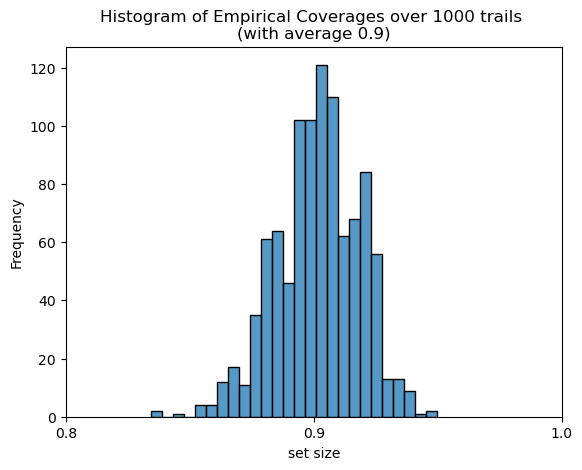

In [2]:
from CP import CP
## APS
### correctness check
cp = CP("LogitRgrssn", smx=smx, labels=labels, n_cali=1112)
scores = cp.get_APS_score(smx, labels)
cp.cc(scores)

The empirical coverage is: 0.9271356783919598


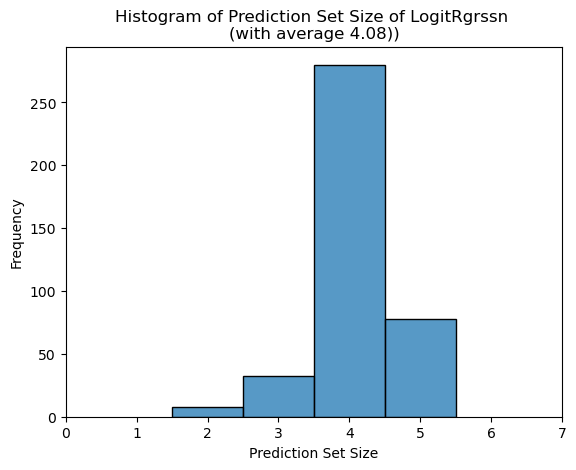

The feature-stratified coverage array is:
 [0.71428571 0.76470588 0.81034483 0.75       0.81395349 0.99609375
 0.88888889]
The size-stratified coverage array is:
 [       nan 0.5        0.93589744]


C:\Users\20878\221Project\HAM10K\CP.py:91: RuntimeWarning: Mean of empty slice.
  tmp = self.prediction_sets[idx[f"{i+1}"], self.val_labels[idx[f"{i+1}"]]].mean()
C:\Users\20878\anaconda3\envs\sklearn\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [4]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
for i in range(20):
    cp = CP("LogitRgrssn", smx=smx, labels=labels, n_cali=1112)
    ps = cp.get_APS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

the empirical coverage for each data split is:
 [0.8693467336683417, 0.9170854271356784, 0.8944723618090452, 0.8869346733668342, 0.8944723618090452, 0.8768844221105527, 0.8819095477386935, 0.8869346733668342, 0.8944723618090452, 0.9195979899497487, 0.9020100502512562, 0.8969849246231156, 0.907035175879397, 0.9170854271356784, 0.8894472361809045, 0.9095477386934674, 0.9045226130653267, 0.9246231155778895, 0.9020100502512562, 0.8894472361809045]
the average size of prediction sets for each data split is:
 [3.76, 4.04, 3.9, 3.89, 3.9, 3.82, 3.81, 3.87, 3.92, 3.97, 3.9, 3.92, 3.94, 4.02, 3.88, 3.97, 3.93, 4.09, 3.94, 3.88]
the fsc metric for each data split is:
 [0.5789473684210527, 0.6, 0.5, 0.4166666666666667, 0.5625, 0.375, 0.5714285714285714, 0.5833333333333334, 0.6666666666666666, 0.7333333333333333, 0.6896551724137931, 0.4, 0.5555555555555556, 0.7, 0.6, 0.6, 0.625, 0.5454545454545454, 0.5, 0.5555555555555556]
the ssc metric for each data split is:
 [0.7058823529411765, 0.5, 0.4545454

The empirical coverage is: 0.979381443298969


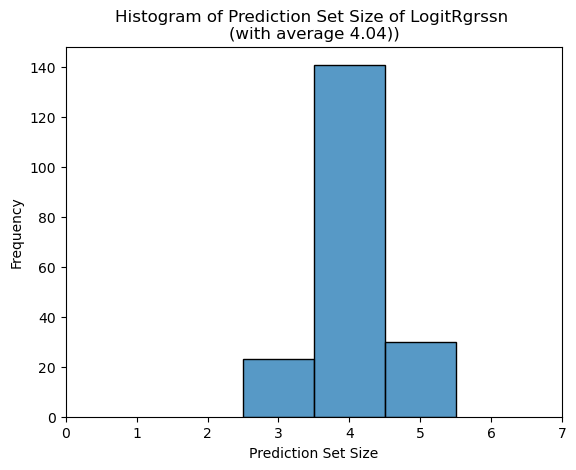

The feature-stratified coverage array is:
 [1.         0.93333333 0.86363636 1.         1.         1.
 1.        ]
The size-stratified coverage array is:
 [       nan        nan 0.97938144]


C:\Users\20878\221Project\HAM10K\CP.py:91: RuntimeWarning: Mean of empty slice.
  tmp = self.prediction_sets[idx[f"{i+1}"], self.val_labels[idx[f"{i+1}"]]].mean()
C:\Users\20878\anaconda3\envs\sklearn\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP("LogitRgrssn", cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val)
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [6]:
## RAPS
### CV for hyper parameters lam_reg and k_reg
cp = CP("LogitRgrssn", sc=1, smx=smx, labels=labels, n_cali=1112)
cp.cv_hypas()

Optimal parameters: lam_reg=0.05, k_reg=2
Coverage: 0.8983912483912485, Average set size: 3.6915057915057914


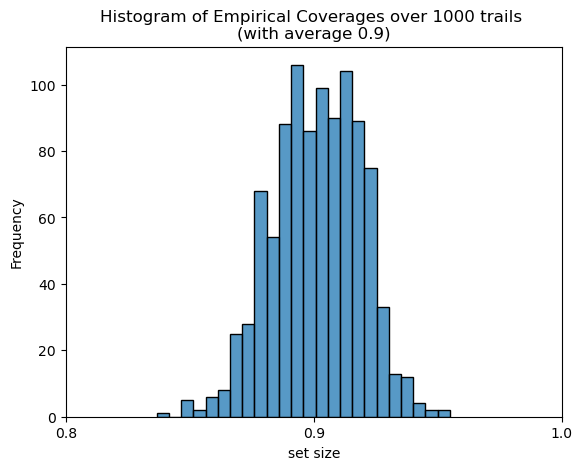

In [7]:
## correctness check
scores = cp.get_RAPS_score(heu_score=smx, lbs=labels)
cp.cc(scores)

In [8]:
lam_reg=1e-2
k_reg=0

The empirical coverage is: 0.8793969849246231


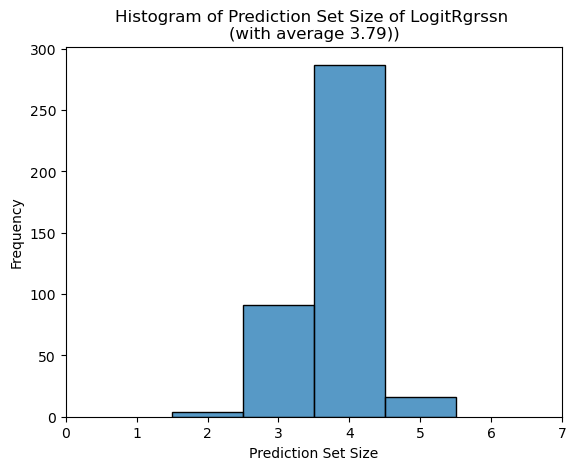

The feature-stratified coverage array is:
 [0.9        0.58823529 0.67741935 0.73333333 0.80952381 0.99173554
 0.4       ]
The size-stratified coverage array is:
 [       nan 0.5        0.88324873]


C:\Users\20878\221Project\HAM10K\CP.py:91: RuntimeWarning: Mean of empty slice.
  tmp = self.prediction_sets[idx[f"{i+1}"], self.val_labels[idx[f"{i+1}"]]].mean()
C:\Users\20878\anaconda3\envs\sklearn\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [24]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
N = 1000
for i in range(N):
    cp = CP("LogitRgrssn", sc=1, smx=smx, labels=labels, n_cali=1112, k_reg=k_reg, lam_reg=lam_reg)
    ps = cp.get_RAPS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))

np.save(f"{data_root}/{suf}/emp_cover_raps.npy", ec_list)
np.save(f"{data_root}/{suf}/sps_raps.npy", sps_avg_list)
np.save(f"{data_root}/{suf}/fsc_raps.npy", fsc_list)
np.save(f"{data_root}/{suf}/ssc_raps.npy", ssc_list)

In [ ]:
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

The empirical coverage is: 0.9742268041237113


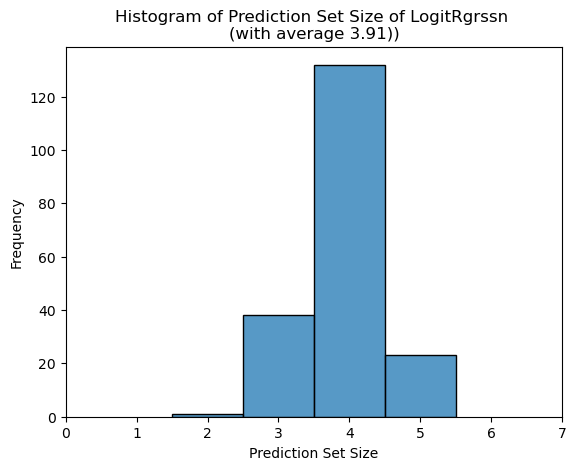

The feature-stratified coverage array is:
 [1.         0.86666667 0.86363636 1.         1.         1.
 1.        ]
The size-stratified coverage array is:
 [       nan 1.         0.97409326]


C:\Users\20878\221Project\HAM10K\CP.py:91: RuntimeWarning: Mean of empty slice.
  tmp = self.prediction_sets[idx[f"{i+1}"], self.val_labels[idx[f"{i+1}"]]].mean()
C:\Users\20878\anaconda3\envs\sklearn\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP("LogitRgrssn", sc=1, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val, k_reg=k_reg, lam_reg=lam_reg)
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()